In [58]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json
import xlsxwriter
import time
import pickle
sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

arn:aws:iam::674283286888:role/arcnext


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise  import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [3]:
DATA_DIR = './data/'


## Combine df

In [5]:
df1 = pd.read_csv(DATA_DIR+'archelp_201808.zip')

In [7]:
df2 = pd.read_csv(DATA_DIR+'archelp_201807.zip')
df3 = pd.read_csv(DATA_DIR+'archelp_201804-06.zip')

In [8]:
df = pd.concat([df1,df2,df3])

In [9]:
df.head()

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch
0,[Failed Checks/Issues:<br>--------------------...,Dev Ops,ejf,Failed Checks/Issues:<br>---------------------...,"(parsrusr,)",503895.0,Parsers,Assigned,NaN,EJF.PROD | Daily Parser Run Tracker : 20180801,02/08/2018,1.533182e+09
1,[Failed Checks/Issues:<br>--------------------...,Dev Ops,baam,Failed Checks/Issues:<br>---------------------...,"(parsrusr,)",503897.0,Parsers,Assigned,NaN,BAAM.PROD | Daily Parser Run Tracker : 20180801,02/08/2018,1.533182e+09
2,[Successful Checks:<br>------------------<br> ...,Dev Ops,baly,Successful Checks:<br>------------------<br> -...,"(parsrusr,)",503899.0,Parsers,Assigned,NaN,BALY.PROD | Daily Parser Run Tracker : 20180801,02/08/2018,1.533183e+09
3,[ \nLink ...,Tech Ops,baam,\nLink ...,"(gundu,)",503902.0,Alerts,Assigned,NaN,UAT Memory Utilization Alert on app1a.baamuat....,02/08/2018,1.533183e+09
4,[ \nLink ...,Tech Ops,baly,\nLink ...,"(gundu,)",503905.0,Alerts,Assigned,NaN,CPU Utilization Alert on app2a.baly.c.ia55.net,02/08/2018,1.533183e+09


In [5]:
# df = pd.read_csv(DATA_DIR+'geneva_user_2016_level_1.csv')
# df = pd.read_csv(DATA_DIR+'geneva_2017_level_1.csv')

In [6]:
df.head()

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
0,[this ticket is with regards to omni testing i...,Dev Ops,baly,this ticket is with regards to omni testing in...,"kassel,",442368,Geneva,Other,sandbox environment set up for omni testing,30/04/2018,1.525126e+09,sandbox environment set up for omni testing t...
1,[hi team please look into the below issue fa...,Tech Ops,baly,hi team please look into the below issue fac...,"bashir,",221184,Geneva,Other,job dw_run_task - arcesiumupdatechangesprocess...,06/03/2017,1.488780e+09,job dw_run_task - arcesiumupdatechangesprocess...
2,[hi team the below 8 best entries are not ge...,Dev Ops,jpm,hi team the below 8 best entries are not get...,"agarwhar,",409602,Geneva,BEST,jpm best entries not getting synced to geneva,05/03/2018,1.520275e+09,jpm best entries not getting synced to genev...
3,[hi tech ops a new book accounting/orienteer...,Dev Ops,desco,hi tech ops a new book accounting/orienteerx...,"samsukha,",297643,Geneva,PnL Run,trigger pnl run 7th aug 9 30 am accountin...,04/08/2017,1.501843e+09,trigger pnl run 7th aug 9 30 am accountin...
4,[hi gto for the latest aemf pnl url the j...,Dev Ops,baly,hi gto for the latest aemf pnl url the je...,"mukhisar,",139268,Geneva,JE Line,jeline completion message published after failure,19/09/2016,1.474283e+09,jeline completion message published after fail...


### Fetch unique loggers and filter out System logged requests for initial pipeline

In [11]:
df.dtypes

All Description     object
Category            object
Client Code         object
Description         object
Logger              object
Request Id         float64
Service             object
Status_0            object
Sub-Service         object
Subject             object
UpdatedDate         object
UpdatedEpoch       float64
dtype: object

In [12]:
df.Logger = df.Logger.apply(lambda x: str(x).strip('()'))

In [13]:
df.Logger.unique()

array(['parsrusr,', 'gundu,', 'borahalb,', ..., 'jainha,', 'lahotip,',
       'tzaman@bamfunds.com,'], dtype=object)

In [14]:
# df.groupby('Logger').agg(['count'])
count = df.groupby(['Logger']).size()

In [15]:
count.sort_values(ascending=False)

Logger
parsrusr,                                     496
jpmorgan.web.account@jpmchase.com,            444
kotharit,                                     403
guptavip,                                     368
sqlexec,                                      347
chenju,                                       318
caldeira,                                     287
dhingra,                                      265
kumarash,                                     263
grozdic,                                      251
ahmedkha,                                     249
sekri,                                        248
pandepra,                                     241
nallanch,                                     240
stpusr,                                       227
prakashp,                                     216
shahsm,                                       206
singhpin,                                     180
agarwhar,                                     175
yadavm,                                    

In [19]:
df2 = df[df['Logger'].str.contains('usr') == False]

In [20]:
# df = df[df.Logger != ('gendev,')]

In [24]:
df2 = df2[df2['Logger'].str.contains('user') == False]
df2 = df2[df2['Logger'].str.contains('@') == False]
df2 = df2[df2['Logger'].str.contains('gendev') == False]
df2 = df2[df2['Logger'].str.contains('dev') == False]

In [25]:
df2.shape

(22179, 12)

In [26]:
df.shape

(29712, 12)

In [14]:
df2 = df.sort_values('Request Id')

In [15]:
df2.tail()

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
22169,[hi team the otc payment blotter in baam recon...,Service Desk,baam,hi team the otc payment blotter in baam reconc...,"muppalan,",523856,Wires,Pending,NaN,baam otc payment blotter not opening in the br...,2018-11-26,1.543215e+09,baam otc payment blotter not opening in the br...,baam otc payment blotter not opening in the br...
22170,[ hi db kindly note down our election preferen...,Service Desk,desco,hi db kindly note down our election preferenc...,"pandepra,",523862,NaN,Pending QA,NaN,desco election submission - db ticker trig ln ...,2018-11-26,1.543217e+09,desco election submission - db ticker trig ln ...,desco election submission - db ticker trig ln ...
22171,[ ],Service Desk,Test,NaN,"agarwhar,",523869,NaN,Pending,NaN,test,2018-11-26,1.543221e+09,NaN,test [ ]
22172,[hi techops could you please run the attached ...,Service Desk,baly,hi techops could you please run the attached c...,"ratha,",523871,Linux,Pending,Command Execution,bundle transfer cancel in baly uat,2018-11-26,1.543222e+09,bundle transfer cancel in baly uat hi techops...,bundle transfer cancel in baly uat [hi techop...
22173,[hi team we see that je line sync has failed f...,Service Desk,desco,hi team we see that je line sync has failed fo...,"maheshan,",523885,Geneva,Pending,Geneva Sync,je line issue 11/23 v2 jpeq_val,2018-11-26,1.543227e+09,je line issue 11/23 v2 jpeq_val hi team we se...,je line issue 11/23 v2 jpeq_val [hi team we s...


In [32]:
## remove Nan rows
df2 = df2.dropna(subset = ['Request Id'])

In [37]:
df2.to_csv(DATA_DIR+'archelp_users_201804-11.csv', index=False)
# df2.to_csv(DATA_DIR+'archelp_users_201804-11.zip', index=False,  encoding='utf-8',compression='zip')

FileNotFoundError: [Errno 2] No such file or directory: './data/archelp_users_201804-11.zip'

In [42]:
df = df2

In [55]:
li = "sdvsd      sdv  sfdgbrg  efg fdbb"
li.replace("  "," ")
re.sub(" +"," ",li)

'sdvsd sdv sfdgbrg efg fdbb'

## Functions

In [72]:
# Cleaning level-1
def clean_delimiters(line):
    line = str(line)
    ## \xa0 is non-breaking space in Latin1 (ISO 8859-1), also chr(160)
    line = line.replace("\r", " ").replace("\\r", " ").replace("\n", " ").replace(
        "\\n", " ").replace("\t", " ").replace("\\t", " ").replace("\"", "").replace(
        ",", " ").replace("|", " ").replace(":", " ").replace("--", "").replace(u'\xa0', u' ').replace("<br>", "")
    return re.sub(" +"," ",line)


def clean_image(line):
    line = str(line)
    #     we dont use gifs for any relevant info
    #     ignoring jpegs for now
    result = re.sub(r"\S+png\S+", "IMAGE", line)
    return re.sub(r"\S+png\S+", "IMAGE", result)


def clean_urls(line):
    line = str(line)
    #     remove images before this
    #     removing <<url>> and url patterns
    result = re.sub(r"<<http\S+", "URL", line)
    return re.sub(r"http\S+", "URL", result)


def small_case(line):
    line = str(line)
    return line.lower()
#     sd.Description.str.lower()

In [76]:
clean_delimiters(df['All Description'][0])

"[hi demon-ops this is a heads-up and is required for onboarding for the new client. we are making some changes to the database 'corpact_master' in dbgelbasenyc in desco. we would like the changes in the database to be captured in the python dbo modules which are available in base. since an entire base sync would take considerable turnaround time we would like the individual module from /prod/tools/base/lib/python/deshaw/dbo/corpact_master.py to be available in arcesium base library. please note this module needs to be available for all aws clients (and not limited to desco pod). we (trd-cat-ops) will take care of making sure that the changes are disted to the production location in desco before you can start work on the arcesium side. the above changes will be coming your way early next week. please let us know the turnaround time involved from your side so that we can plan the work accordingly. also let me know if there any additional questions here. thanks mohan. p.s. i'm assigning 

In [73]:
# apply functions till level-1 to df
df['All Description'] = df['All Description'].apply(clean_image)
df['All Description'] = df['All Description'].apply(clean_urls)
df['All Description'] = df['All Description'].apply(small_case)
df['All Description'] = df['All Description'].apply(clean_delimiters)

In [78]:
df['Description'] = df['Description'].apply(clean_image)
df['Description'] = df['Description'].apply(clean_urls)
df['Description'] = df['Description'].apply(small_case)
df['Description'] = df['Description'].apply(clean_delimiters)

In [79]:
str(df.Description[:1])

'13796    alert dbmonitor check-databaseaudit database i...\nName: Description, dtype: object'

In [80]:
list(df.Description[:1])

["alert dbmonitor check-databaseaudit database instance dbmonitorexecution time 4/2/2018 12 03 27 amview alert status '(dba) check-databaseaudit' job on dbmonitor alert parameters description the following database(s) have audit enabled.please review the audit from dba request and take necessary action. server_name balydb1a server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balydb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balysandboxdb1b server_audit_name server_is_state_enabled db_name geneva_warehouse db_audit_name audit_dba_211076 db_is_state_enabled true server_name balyuatdb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true note a reminder email will be sent."]

In [68]:
df
# 19783 rows × 9 columns

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
13796,[alert dbmonitor check-databaseaud...,DBA Ops,shared,alert dbmonitor check-databaseaudi...,"raot,",425179.0,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,02/04/2018,1.522642e+09,dbmonitor check-databaseaudit alert alert ...
13807,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210.0,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,02/04/2018,1.522644e+09,baly.prod pnl runtime tracking - april 2018 ...
13809,[ linked all balyuat pnl's to this ticket and ...,Dev Ops,baly,nan,"gavara,",425217.0,GEAR,Pending,PNL,balyuat pnl failures - 20180402,02/04/2018,1.522644e+09,balyuat pnl failures - 20180402 nan
13823,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243.0,Parsers,Pending,NaN,desco converts file parser 0330,02/04/2018,1.522646e+09,desco converts file parser 0330 hi itsm t...
13826,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253.0,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,02/04/2018,1.522646e+09,jpm prod trade processing hi team jpm h...
13828,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256.0,Parsers,Pending,NaN,normalization update index future swaps gs...,02/04/2018,1.522647e+09,normalization update index future swaps gs...
13830,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260.0,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,02/04/2018,1.522648e+09,break glass access baly baam ejf hi tec...
13831,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261.0,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,02/04/2018,1.522648e+09,geneva1a.mars ebs root disk space issues eb...
13840,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274.0,User Access,Pending,SSH Break Glass,ssh on baly.prod,02/04/2018,1.522650e+09,ssh on baly.prod hi tech ops please provide...
13841,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276.0,DARTS,Pending,NaN,jpm.prod manual_price_alert config change ...,02/04/2018,1.522651e+09,jpm.prod manual_price_alert config change ...


In [81]:
df.Subject = df.Subject.apply(clean_image)
df.Subject = df.Subject.apply(clean_urls)
df.Subject = df.Subject.apply(small_case)
df.Subject = df.Subject.apply(clean_delimiters)

In [49]:
df

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch
13796,[alert dbmonitor check-databaseau...,DBA Ops,shared,alert dbmonitor check-databaseaud...,"raot,",425179.0,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,02/04/2018,1.522642e+09
13807,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210.0,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,02/04/2018,1.522644e+09
13809,[ linked all balyuat pnl's to this ticket a...,Dev Ops,baly,nan,"gavara,",425217.0,GEAR,Pending,PNL,balyuat pnl failures - 20180402,02/04/2018,1.522644e+09
13823,[hi itsm team this is similar to archelp#27...,Tech Ops,desco,hi itsm team this is similar to archelp#270...,"bohra,",425243.0,Parsers,Pending,NaN,desco converts file parser 0330,02/04/2018,1.522646e+09
13826,[hi team jpm has raised the below issue in a...,Dev Ops,jpm,hi team jpm has raised the below issue in a ...,"srivasar,",425253.0,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,02/04/2018,1.522646e+09
13828,[hi parser team similar to ticket archelp#41...,Dev Ops,desco,hi parser team similar to ticket archelp#416...,"maheshan,",425256.0,Parsers,Pending,NaN,normalization update index future swaps gs...,02/04/2018,1.522647e+09
13830,[hi techops could you grant me break glass a...,Tech Ops,baly,hi techops could you grant me break glass ac...,"gurudu,",425260.0,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,02/04/2018,1.522648e+09
13831,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261.0,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,02/04/2018,1.522648e+09
13840,[hi tech ops please provide permission to ss...,Tech Ops,baly,hi tech ops please provide permission to ssh...,"singhris,",425274.0,User Access,Pending,SSH Break Glass,ssh on baly.prod,02/04/2018,1.522650e+09
13841,[hi darts team the thread responsible for lo...,Dev Ops,jpm,hi darts team the thread responsible for log...,"narayan,",425276.0,DARTS,Pending,NaN,jpm.prod manual_price_alert config change ...,02/04/2018,1.522651e+09


In [83]:
df.dtypes

All Description     object
Category            object
Client Code         object
Description         object
Logger              object
Request Id         float64
Service             object
Status_0            object
Sub-Service         object
Subject             object
UpdatedDate         object
UpdatedEpoch       float64
Concated            object
dtype: object

In [84]:
df = df.astype({'Request Id':int})

In [85]:
df.dtypes

All Description     object
Category            object
Client Code         object
Description         object
Logger              object
Request Id           int64
Service             object
Status_0            object
Sub-Service         object
Subject             object
UpdatedDate         object
UpdatedEpoch       float64
Concated            object
dtype: object

In [74]:
# df['Concated'] = df['Subject'] + '  ' + df['All Description']
df['Concated'] = df['Subject'] + '  ' + df['Description']
df['All Concated'] = df['Subject'] + '  ' + df['All Description']

In [75]:
df

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,2018-04-02,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...,dbmonitor check-databaseaudit alert [alert db...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,2018-04-02,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...,baly.prod pnl runtime tracking - april 2018 [...
2,[ linked all balyuat pnl's to this ticket and ...,Dev Ops,baly,NaN,"gavara,",425217,GEAR,Pending,PNL,balyuat pnl failures - 20180402,2018-04-02,1.522644e+09,NaN,balyuat pnl failures - 20180402 [ linked all ...
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,2018-04-02,1.522646e+09,desco converts file parser 0330 hi itsm team ...,desco converts file parser 0330 [hi itsm team...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,2018-04-02,1.522646e+09,jpm prod trade processing hi team jpm has rai...,jpm prod trade processing [hi team jpm has ra...
5,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256,Parsers,Pending,NaN,normalization update index future swaps gsi_jp...,2018-04-02,1.522647e+09,normalization update index future swaps gsi_jp...,normalization update index future swaps gsi_jp...
6,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,2018-04-02,1.522648e+09,break glass access baly baam ejf hi techops c...,break glass access baly baam ejf [hi techops ...
7,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,2018-04-02,1.522648e+09,geneva1a.mars ebs root disk space issues ebs ...,geneva1a.mars ebs root disk space issues [ebs...
8,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274,User Access,Pending,SSH Break Glass,ssh on baly.prod,2018-04-02,1.522650e+09,ssh on baly.prod hi tech ops please provide p...,ssh on baly.prod [hi tech ops please provide ...
9,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276,DARTS,Pending,NaN,jpm.prod manual_price_alert config change history,2018-04-02,1.522651e+09,jpm.prod manual_price_alert config change hist...,jpm.prod manual_price_alert config change hist...


In [86]:
list(df.Concated[:1])

["dbmonitor check-databaseaudit alert  alert dbmonitor check-databaseaudit database instance dbmonitorexecution time 4/2/2018 12 03 27 amview alert status '(dba) check-databaseaudit' job on dbmonitor alert parameters description the following database(s) have audit enabled.please review the audit from dba request and take necessary action. server_name balydb1a server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balydb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balysandboxdb1b server_audit_name server_is_state_enabled db_name geneva_warehouse db_audit_name audit_dba_211076 db_is_state_enabled true server_name balyuatdb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true note a reminder email will be sent."]

In [24]:
!ls

data	    nlp-explore-1-Copy1.ipynb  Universal-Sentence-Encoder-2.ipynb
lost+found  nlp-explore-1.ipynb


In [87]:
!ls ./data/

all_user_2018.zip		 geneva_user_2016_level_1.csv
archelp_201804-06.zip		 pcg_all_sept_level_1.csv
archelp_201807.zip		 pmg_all_sept.csv.zip
archelp_201808.zip		 pmg_sept.csv.zip
archelp_users_201804-11.csv	 similar-2.xlsx
archelp_users_201804-11.csv.zip  similar.xlsx
blazingtext_similar.xlsx	 test.txt
geneva_test.txt			 train_embeddings.npy
geneva_train.txt		 train_embeddings.npz
geneva_user_2016.csv.zip	 train.txt


In [77]:
# df.to_csv(DATA_DIR+'geneva_2017_level_1.csv',index=False)
df.to_csv('./data/archelp_user_201804-11_level_2.csv',index=False)

## Data Subset

In [44]:
other = df[df['Sub-Service'] == 'Other']

In [45]:
other
# 6284 rows × 9 columns

,Category,Client Code,Description,Logger,Request Id,Service,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
9,Dev Ops,desco,hi we don't see the financing getting refres...,"singhva,",358562,Geneva,Other,mtm ui refresh issue - macro/kal,29/11/2017,1.511971e+09,mtm ui refresh issue - macro/kal hi we don'...
12,Dev Ops,desco,recent changes geneva primary url is sev...,"kumarrav,",345045,Geneva,Other,[ geneva primary ] is severe,06/11/2017,1.509978e+09,[ geneva primary ] is severe recent changes ...
13,Dev Ops,baly,hi team feature(s) ...,"joshir,",342011,Geneva,Other,reorg future cost getting computed incorrectly,31/10/2017,1.509487e+09,reorg future cost getting computed incorrectl...
41,Tech Ops,baly,tracking all sodasia pnl failures here. ravi,"kumarrav,",334252,Geneva,Other,pnl failures on baly,17/10/2017,1.508261e+09,pnl failures on baly tracking all sodasia pnl...
62,Dev Ops,baly,prabhu as discussed offline please apply t...,"singhn,",324885,Geneva,Other,apply baly license tomorrow morning hyd,29/09/2017,1.506695e+09,apply baly license tomorrow morning hyd prabh...
71,Dev Ops,baly,+archelp ___________________________________...,"kathuria,",316736,Geneva,Other,re baly pnl failing for 09-13,13/09/2017,1.505339e+09,re baly pnl failing for 09-13 +archelp ___...
75,Dev Ops,shared,hi gendev munshi-geneva service is not coming...,"gavara,",298247,Geneva,Other,munshi-geneva service is not coming up on baly...,06/08/2017,1.502069e+09,munshi-geneva service is not coming up on baly...
89,Dev Ops,baly,hi gendev we see many trades missing in genev...,"mittal,",225889,Geneva,Other,baly trades missing in geneva,12/03/2017,1.489324e+09,baly trades missing in geneva hi gendev we...
91,Dev Ops,baly,hi team the data for bridge wires is not sy...,"agarashi,",218433,Geneva,Other,baly je lines run id 2840675 & 2840672 not...,28/02/2017,1.488285e+09,baly je lines run id 2840675 & 2840672 not...
92,Dev Ops,desco,hi all the second run of fx report(file name...,"saxenaak,",217000,Geneva,Other,second run of fx report not available for 02/2...,24/02/2017,1.487941e+09,second run of fx report not available for 02/2...


## taking 90% to train and 10 % to test

In [28]:
df = pd.read_csv('./data/archelp_users_201804-11_level_1.csv')

In [29]:
df.head()

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,02/04/2018,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,02/04/2018,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...
2,[ linked all balyuat pnl's to this ticket and ...,Dev Ops,baly,NaN,"gavara,",425217,GEAR,Pending,PNL,balyuat pnl failures - 20180402,02/04/2018,1.522644e+09,balyuat pnl failures - 20180402 nan
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,02/04/2018,1.522646e+09,desco converts file parser 0330 hi itsm team ...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,02/04/2018,1.522646e+09,jpm prod trade processing hi team jpm has rai...


In [9]:
df.tail(10)

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
22164,[hi team jpm unable to open failed objects scr...,Service Desk,jpm,hi team jpm unable to open failed objects scre...,"grovera,",523825,Geneva,Awaiting Response,Failed Object,jpm not able to access failed objects screen,25/11/2018,1.543205e+09,jpm not able to access failed objects screen ...
22165,[hi baml we have the below event approaching t...,Service Desk,baly,hi baml we have the below event approaching th...,"caldeira,",523844,NaN,Pending,NaN,baly baml confirm election deadline 4921 jt se...,26/11/2018,1.543211e+09,baly baml confirm election deadline 4921 jt se...
22166,[hi seb we have the below event approaching th...,Service Desk,baly,hi seb we have the below event approaching the...,"caldeira,",523845,NaN,Pending,NaN,baly seb confirm election deadline cinn ss sed...,26/11/2018,1.543211e+09,baly seb confirm election deadline cinn ss sed...
22167,[hi team we see the fund allocation screen is ...,Service Desk,jpm,hi team we see the fund allocation screen is n...,"maurya,",523852,FuMA,Assigned,NaN,fuma screen not opening,26/11/2018,1.543214e+09,fuma screen not opening hi team we see the fu...
22168,[hi team we see that the wires screen is not w...,Service Desk,jpm,hi team we see that the wires screen is not wo...,"grovera,",523853,Wires,Awaiting Response,NaN,wires screen not working,26/11/2018,1.543214e+09,wires screen not working hi team we see that ...
22169,[hi team the otc payment blotter in baam recon...,Service Desk,baam,hi team the otc payment blotter in baam reconc...,"muppalan,",523856,Wires,Pending,NaN,baam otc payment blotter not opening in the br...,26/11/2018,1.543215e+09,baam otc payment blotter not opening in the br...
22170,[ hi db kindly note down our election preferen...,Service Desk,desco,hi db kindly note down our election preferenc...,"pandepra,",523862,NaN,Pending QA,NaN,desco election submission - db ticker trig ln ...,26/11/2018,1.543217e+09,desco election submission - db ticker trig ln ...
22171,[ ],Service Desk,Test,NaN,"agarwhar,",523869,NaN,Pending,NaN,test,26/11/2018,1.543221e+09,test nan
22172,[hi techops could you please run the attached ...,Service Desk,baly,hi techops could you please run the attached c...,"ratha,",523871,Linux,Pending,Command Execution,bundle transfer cancel in baly uat,26/11/2018,1.543222e+09,bundle transfer cancel in baly uat hi techops...
22173,[hi team we see that je line sync has failed f...,Service Desk,desco,hi team we see that je line sync has failed fo...,"maheshan,",523885,Geneva,Pending,Geneva Sync,je line issue 11/23 v2 jpeq_val,26/11/2018,1.543227e+09,je line issue 11/23 v2 jpeq_val hi team we se...


In [34]:
df.tail(10)

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated
22164,[hi team jpm unable to open failed objects scr...,Service Desk,jpm,hi team jpm unable to open failed objects scre...,"grovera,",523825,Geneva,Awaiting Response,Failed Object,jpm not able to access failed objects screen,2018-11-25,1.543205e+09,jpm not able to access failed objects screen ...
22165,[hi baml we have the below event approaching t...,Service Desk,baly,hi baml we have the below event approaching th...,"caldeira,",523844,NaN,Pending,NaN,baly baml confirm election deadline 4921 jt se...,2018-11-26,1.543211e+09,baly baml confirm election deadline 4921 jt se...
22166,[hi seb we have the below event approaching th...,Service Desk,baly,hi seb we have the below event approaching the...,"caldeira,",523845,NaN,Pending,NaN,baly seb confirm election deadline cinn ss sed...,2018-11-26,1.543211e+09,baly seb confirm election deadline cinn ss sed...
22167,[hi team we see the fund allocation screen is ...,Service Desk,jpm,hi team we see the fund allocation screen is n...,"maurya,",523852,FuMA,Assigned,NaN,fuma screen not opening,2018-11-26,1.543214e+09,fuma screen not opening hi team we see the fu...
22168,[hi team we see that the wires screen is not w...,Service Desk,jpm,hi team we see that the wires screen is not wo...,"grovera,",523853,Wires,Awaiting Response,NaN,wires screen not working,2018-11-26,1.543214e+09,wires screen not working hi team we see that ...
22169,[hi team the otc payment blotter in baam recon...,Service Desk,baam,hi team the otc payment blotter in baam reconc...,"muppalan,",523856,Wires,Pending,NaN,baam otc payment blotter not opening in the br...,2018-11-26,1.543215e+09,baam otc payment blotter not opening in the br...
22170,[ hi db kindly note down our election preferen...,Service Desk,desco,hi db kindly note down our election preferenc...,"pandepra,",523862,NaN,Pending QA,NaN,desco election submission - db ticker trig ln ...,2018-11-26,1.543217e+09,desco election submission - db ticker trig ln ...
22171,[ ],Service Desk,Test,NaN,"agarwhar,",523869,NaN,Pending,NaN,test,2018-11-26,1.543221e+09,test nan
22172,[hi techops could you please run the attached ...,Service Desk,baly,hi techops could you please run the attached c...,"ratha,",523871,Linux,Pending,Command Execution,bundle transfer cancel in baly uat,2018-11-26,1.543222e+09,bundle transfer cancel in baly uat hi techops...
22173,[hi team we see that je line sync has failed f...,Service Desk,desco,hi team we see that je line sync has failed fo...,"maheshan,",523885,Geneva,Pending,Geneva Sync,je line issue 11/23 v2 jpeq_val,2018-11-26,1.543227e+09,je line issue 11/23 v2 jpeq_val hi team we se...


In [22]:
df['UpdatedDate'] = pd.to_datetime(df['UpdatedDate'], format='%Y-%m-%d')

In [23]:
df.dtypes

All Description            object
Category                   object
Client Code                object
Description                object
Logger                     object
Request Id                  int64
Service                    object
Status_0                   object
Sub-Service                object
Subject                    object
UpdatedDate        datetime64[ns]
UpdatedEpoch              float64
Concated                   object
All Concated               object
dtype: object

In [24]:
df[df.UpdatedDate.dt.month <= 8]

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,2018-04-02,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...,dbmonitor check-databaseaudit alert [alert db...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,2018-04-02,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...,baly.prod pnl runtime tracking - april 2018 [...
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,2018-04-02,1.522646e+09,desco converts file parser 0330 hi itsm team ...,desco converts file parser 0330 [hi itsm team...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,2018-04-02,1.522646e+09,jpm prod trade processing hi team jpm has rai...,jpm prod trade processing [hi team jpm has ra...
5,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256,Parsers,Pending,NaN,normalization update index future swaps gsi_jp...,2018-04-02,1.522647e+09,normalization update index future swaps gsi_jp...,normalization update index future swaps gsi_jp...
6,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,2018-04-02,1.522648e+09,break glass access baly baam ejf hi techops c...,break glass access baly baam ejf [hi techops ...
7,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,2018-04-02,1.522648e+09,geneva1a.mars ebs root disk space issues ebs ...,geneva1a.mars ebs root disk space issues [ebs...
8,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274,User Access,Pending,SSH Break Glass,ssh on baly.prod,2018-04-02,1.522650e+09,ssh on baly.prod hi tech ops please provide p...,ssh on baly.prod [hi tech ops please provide ...
9,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276,DARTS,Pending,NaN,jpm.prod manual_price_alert config change history,2018-04-02,1.522651e+09,jpm.prod manual_price_alert config change hist...,jpm.prod manual_price_alert config change hist...
10,[techops i could see munshi-ui up and running ...,Tech Ops,desco,techops i could see munshi-ui up and running o...,"nethik,",425281,Munshi Geneva,Pending,NaN,deshawuat munshi ui not accessible,2018-04-02,1.522651e+09,deshawuat munshi ui not accessible techops i ...,deshawuat munshi ui not accessible [techops i...


In [25]:
df

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,2018-04-02,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...,dbmonitor check-databaseaudit alert [alert db...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,2018-04-02,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...,baly.prod pnl runtime tracking - april 2018 [...
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,2018-04-02,1.522646e+09,desco converts file parser 0330 hi itsm team ...,desco converts file parser 0330 [hi itsm team...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,2018-04-02,1.522646e+09,jpm prod trade processing hi team jpm has rai...,jpm prod trade processing [hi team jpm has ra...
5,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256,Parsers,Pending,NaN,normalization update index future swaps gsi_jp...,2018-04-02,1.522647e+09,normalization update index future swaps gsi_jp...,normalization update index future swaps gsi_jp...
6,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,2018-04-02,1.522648e+09,break glass access baly baam ejf hi techops c...,break glass access baly baam ejf [hi techops ...
7,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,2018-04-02,1.522648e+09,geneva1a.mars ebs root disk space issues ebs ...,geneva1a.mars ebs root disk space issues [ebs...
8,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274,User Access,Pending,SSH Break Glass,ssh on baly.prod,2018-04-02,1.522650e+09,ssh on baly.prod hi tech ops please provide p...,ssh on baly.prod [hi tech ops please provide ...
9,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276,DARTS,Pending,NaN,jpm.prod manual_price_alert config change history,2018-04-02,1.522651e+09,jpm.prod manual_price_alert config change hist...,jpm.prod manual_price_alert config change hist...
10,[techops i could see munshi-ui up and running ...,Tech Ops,desco,techops i could see munshi-ui up and running o...,"nethik,",425281,Munshi Geneva,Pending,NaN,deshawuat munshi ui not accessible,2018-04-02,1.522651e+09,deshawuat munshi ui not accessible techops i ...,deshawuat munshi ui not accessible [techops i...


In [17]:
df.dropna(subset = ['Concated'], inplace=True)

In [20]:
df.dtypes

All Description     object
Category            object
Client Code         object
Description         object
Logger              object
Request Id           int64
Service             object
Status_0            object
Sub-Service         object
Subject             object
UpdatedDate         object
UpdatedEpoch       float64
Concated            object
All Concated        object
dtype: object

### delete Error causing rows

In [26]:
df.iloc[[15420]]

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
15518,[hi shubham issue ir futures and treasury futu...,Dev Ops,desco,hi shubham issue ir futures and treasury futur...,"jaiswal,",510002,Treasury,Pending,Margin Rules & Calculators,issue with span simulation,2018-08-16,1.534443e+09,issue with span simulation hi shubham issue i...,issue with span simulation [hi shubham issue ...


In [29]:
##InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation
##(reached max retries: 4): An exception occurred while sending request to model. Please contact customer support
##regarding request 4c5befef-60fa-45a0-9922-cd58da4f648d.

# df.iloc[15422]['Concated']
''''blocked postgres processes dbcocoauat.ia55.net - 8/16/2018-08162018  please investigate
and resolve the following blocking condition.blocked_pid 462blocked_application postgresql jdbc
driverblocked_host 10.12.122.60blocked_user radarblocked_statement select dbalerteve0_.alertsourcekeyeventid
as alertsou1_0_0_ dbalerteve0_.ackdueby as ackdueby2_0_0_ dbalerteve0_.ackdurationinmins as
ackdurat3_0_0_ dbalerteve0_.ackslaviolatedby as ackslavi4_0_0_ dbalerteve0_.ackslaviolatedon as
ackslavi5_0_0_ dbalerteve0_.acknowledgedby as acknowle6_0_0_ dbalerteve0_.acknowledgedon as acknowle7_0_0_
dbalerteve0_.alarmstate as alarmsta8_0_0_ dbalerteve0_.alertid as alertid9_0_0_ dbalerteve0_.alertkey as
alertke10_0_0_ dbalerteve0_.alertrulekey as alertru11_0_0_ dbalerteve0_.alertsource as alertso12_0_0_
dbalerteve0_.alertsourceid as alertso13_0_0_ dbalerteve0_.alertsourcekey as
alertso14_0_0_ dbalerteve0_.assignedby as assigne15_0_0_ dbalerteve0_.assignedon as assigne16_0_0_ dbalerteve0_.assignedto as as'''
df = df.drop(df.index[[15422]])

In [31]:
df.to_csv('./data/archelp_user_201804-11_level_3.csv',index=False)

In [30]:
# df_train, df_test = train_test_split(df,test_size=0.1, random_state=23)#, shuffle=False)
df_train = df[df.UpdatedDate.dt.month <= 8]
df_test = df[df.UpdatedDate.dt.month > 8]

## Making custom train test

In [11]:
id_list = [122963,477243,254325,250389,221566,276626,484498,134054,273333,55238,122273]

In [12]:
# df_train = df[~df['Request Id'].isin(id_list)]
# df_test = df[df['Request Id'].isin(id_list)]

In [98]:
df_train

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,2018-04-02,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...,dbmonitor check-databaseaudit alert [alert db...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,2018-04-02,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...,baly.prod pnl runtime tracking - april 2018 [...
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,2018-04-02,1.522646e+09,desco converts file parser 0330 hi itsm team ...,desco converts file parser 0330 [hi itsm team...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,2018-04-02,1.522646e+09,jpm prod trade processing hi team jpm has rai...,jpm prod trade processing [hi team jpm has ra...
5,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256,Parsers,Pending,NaN,normalization update index future swaps gsi_jp...,2018-04-02,1.522647e+09,normalization update index future swaps gsi_jp...,normalization update index future swaps gsi_jp...
6,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,2018-04-02,1.522648e+09,break glass access baly baam ejf hi techops c...,break glass access baly baam ejf [hi techops ...
7,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,2018-04-02,1.522648e+09,geneva1a.mars ebs root disk space issues ebs ...,geneva1a.mars ebs root disk space issues [ebs...
8,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274,User Access,Pending,SSH Break Glass,ssh on baly.prod,2018-04-02,1.522650e+09,ssh on baly.prod hi tech ops please provide p...,ssh on baly.prod [hi tech ops please provide ...
9,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276,DARTS,Pending,NaN,jpm.prod manual_price_alert config change history,2018-04-02,1.522651e+09,jpm.prod manual_price_alert config change hist...,jpm.prod manual_price_alert config change hist...
10,[techops i could see munshi-ui up and running ...,Tech Ops,desco,techops i could see munshi-ui up and running o...,"nethik,",425281,Munshi Geneva,Pending,NaN,deshawuat munshi ui not accessible,2018-04-02,1.522651e+09,deshawuat munshi ui not accessible techops i ...,deshawuat munshi ui not accessible [techops i...


In [99]:
df_test

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
16525,[the partition /data/jenkins-aws (netapp-c1-vs...,Service Desk,NaN,the partition /data/jenkins-aws (netapp-c1-vs0...,"root,",512491,NaN,Pending,NaN,disk space warning (/data/jenkins-aws) in nyc,2018-09-02,1.535908e+09,disk space warning (/data/jenkins-aws) in nyc ...,disk space warning (/data/jenkins-aws) in nyc ...
16526,[hi traders could you please provide your elec...,Service Desk,desco,hi traders could you please provide your elect...,"pandepra,",512494,NaN,Pending,NaN,desco election preference - jpnonasm bbg ticke...,2018-09-02,1.535944e+09,desco election preference - jpnonasm bbg ticke...,desco election preference - jpnonasm bbg ticke...
16527,[hi cs kindly note down our election preferenc...,Service Desk,desco,hi cs kindly note down our election preference...,"pandepra,",512495,NaN,Pending,NaN,desco election submission - cs ticker pry_r au...,2018-09-02,1.535944e+09,desco election submission - cs ticker pry_r au...,desco election submission - cs ticker pry_r au...
16528,[hi cs kindly note down our election preferenc...,Service Desk,desco,hi cs kindly note down our election preference...,"pandepra,",512496,NaN,Pending,NaN,desco election submission - cs ticker bin_r au...,2018-09-02,1.535944e+09,desco election submission - cs ticker bin_r au...,desco election submission - cs ticker bin_r au...
16529,[hi traders could you please provide your elec...,Service Desk,desco,hi traders could you please provide your elect...,"pandepra,",512497,NaN,Pending,NaN,desco election preference - jpnonasm bbg ticke...,2018-09-02,1.535946e+09,desco election preference - jpnonasm bbg ticke...,desco election preference - jpnonasm bbg ticke...
16530,[hi ms kindly note down our election preferenc...,Service Desk,desco,hi ms kindly note down our election preference...,"pandepra,",512498,NaN,Pending,NaN,desco election submission - ms ticker pry_r au...,2018-09-02,1.535946e+09,desco election submission - ms ticker pry_r au...,desco election submission - ms ticker pry_r au...
16531,[hi traders could you please provide your elec...,Service Desk,desco,hi traders could you please provide your elect...,"pandepra,",512499,NaN,Pending,NaN,desco election preference - jpnonasm bbg ticke...,2018-09-02,1.535947e+09,desco election preference - jpnonasm bbg ticke...,desco election preference - jpnonasm bbg ticke...
16532,[hi gs we have the below event approaching the...,Service Desk,baly,hi gs we have the below event approaching the ...,"caldeira,",512504,TRD,Pending,Corporate Actions,baly gs confirm election deadline crh id sedol...,2018-09-03,1.535952e+09,baly gs confirm election deadline crh id sedol...,baly gs confirm election deadline crh id sedol...
16533,[hi baml kindly re-route this to the outright ...,Service Desk,baly,hi baml kindly re-route this to the outright u...,"caldeira,",512505,NaN,Pending,NaN,baly baml confirm election deadline psec us b0...,2018-09-03,1.535953e+09,baly baml confirm election deadline psec us b0...,baly baml confirm election deadline psec us b0...
16534,[hi pdo the reins prices did not get updated f...,Service Desk,desco,hi pdo the reins prices did not get updated fo...,"parmarn,",512506,Pricing,Pending,Missing Prices,reins prices not updated for august 31 2018,2018-09-03,1.535953e+09,reins prices not updated for august 31 2018 h...,reins prices not updated for august 31 2018 [...


In [ ]:
making

In [44]:
region_name = boto3.Session().region_name

In [45]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 811284229777.dkr.ecr.us-east-1.amazonaws.com/blazingtext:latest (us-east-1)


In [46]:
print (df_train.shape)
print (df_test.shape)

(16560, 13)
(5614, 13)


In [118]:
train = df_train.Concated.tolist()
all_train = df_train['All Concated'].tolist()
test = df_test.Concated.tolist()

In [48]:
# a = df_train['Concated'].tolist()

In [18]:
li =  df_test['Concated'].tolist()

### Uploading data to S3 bucket

In [49]:
bucket = 'ia55-arcnext'
prefix = 'blazingtext'

In [52]:
train_channel = prefix + '/archelp_train'

# just to test uploading to bucket
# sess.upload_data(path='./explore-1.ipynb', bucket=bucket, key_prefix=train_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)


In [53]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
s3_output_location

's3://ia55-arcnext/blazingtext/output'

In [119]:
# save train file to disk
with open(DATA_DIR+'archelp_train.txt', 'w') as f:
    for item in train:
        f.write("%s\n" % item)
        
# save train file to disk
with open(DATA_DIR+'archelp_all_train.txt', 'w') as f:
    for item in all_train:
        f.write("%s\n" % item)

In [120]:
# save test file to disk
with open(DATA_DIR+'archelp_test.txt', 'w') as f:
    for item in test:
        f.write("%s\n" % item)

In [85]:
#upload file to s3
sess.upload_data(path=DATA_DIR+'archelp_all_train.txt', bucket=bucket, key_prefix=train_channel)
# sess.upload_data(path=DATA_DIR+'test.txt', bucket=bucket, key_prefix=train_channel)

's3://ia55-arcnext/blazingtext/archelp_train/archelp_all_train.txt'

In [86]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

data_channels = {'train':  train_data}

## Training

In [87]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.2xlarge', # Use of ml.p3.2xlarge is highly recommended for highest speed and cost efficiency
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [88]:
bt_model.set_hyperparameters(mode="batch_skipgram",
                             epochs=8,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=5,
                             vector_dim=256,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

In [89]:
bt_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: blazingtext-2018-11-28-10-29-45-282


2018-11-28 10:29:45 Starting - Starting the training job...
2018-11-28 10:29:47 Starting - Launching requested ML instances......
2018-11-28 10:30:50 Starting - Preparing the instances for training......
2018-11-28 10:32:08 Downloading - Downloading input data
2018-11-28 10:32:08 Training - Training image download completed. Training in progress........
Arguments: train
[11/28/2018 10:32:08 WARNING 139966391277376] Loggers have already been setup.
[11/28/2018 10:32:08 WARNING 139966391277376] Loggers have already been setup.
[11/28/2018 10:32:09 INFO 139966391277376] nvidia-smi took: 0.0252401828766 secs to identify 0 gpus
[11/28/2018 10:32:09 INFO 139966391277376] Running single machine CPU BlazingText training using batch_skipgram mode.
[11/28/2018 10:32:09 INFO 139966391277376] Processing /opt/ml/input/data/train/archelp_all_train.txt . File size: 149 MB
Read 10M words
Read 16M words
Number of words:  62975
##### Alpha: 0.0489  Progress: 2.16%  Million Words/sec: 1.17 #####
##### Al

In [ ]:
bt_model.

## Hosting

In [90]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.c5.4xlarge')

INFO:sagemaker:Creating model with name: blazingtext-2018-11-28-10-37-01-165
INFO:sagemaker:Creating endpoint with name blazingtext-2018-11-28-10-29-45-282


---------------------------------------------------!

## Creating Sentence2Vec from Word2vec

In [32]:
train_embeddings  = []
test_embeddings  = []
dim_size = 256

In [21]:
# train = [line.rstrip('\n') for line in open('./data/train.txt')]
# test = [line.rstrip('\n') for line in open('./data/test.txt')]


In [53]:
train[4]

"desco  election preference - peasm   bbg ticker  spsn1 sw   sedol  bgjyxb6   isin  ch0433613186   event  rights [excl]  [hi traders   could you please provide your election preference for the below event       event   spn        name             ticker    sedol    isin          book      prime broker      position  deadline    time / zone          rights  101421798  swiss prime rts  spsn1 sw  bgjyxb6  ch0433613186  peeq/asm  deutsche bank ag  395       2018-09-25  14 00 europe/london                                                                                                                                   option details     001         exercise                               option available option description  exercise securities at the quoted rate(s) to buy new shares at the quoted price in the in the option details section (subject to price information being available). period of action                                   18-sep-2018 to 26-sep-2018 security movement credit/debit

In [66]:
train2 = train[:5]

In [67]:
train2

["dbmonitor check-databaseaudit alert  alert dbmonitor check-databaseaudit database instance dbmonitorexecution time 4/2/2018 12 03 27 amview alert status '(dba) check-databaseaudit' job on dbmonitor alert parameters description the following database(s) have audit enabled.please review the audit from dba request and take necessary action. server_name balydb1a server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balydb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balysandboxdb1b server_audit_name server_is_state_enabled db_name geneva_warehouse db_audit_name audit_dba_211076 db_is_state_enabled true server_name balyuatdb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true note a reminder email will be sent.",
 'baly.prod pnl 

In [95]:
for request in list(df.Concated):
    print (request)
    print (type(request))
    break

dbmonitor check-databaseaudit alert  alert dbmonitor check-databaseaudit database instance dbmonitorexecution time 4/2/2018 12 03 27 amview alert status '(dba) check-databaseaudit' job on dbmonitor alert parameters description the following database(s) have audit enabled.please review the audit from dba request and take necessary action. server_name balydb1a server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balydb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true server_name balysandboxdb1b server_audit_name server_is_state_enabled db_name geneva_warehouse db_audit_name audit_dba_211076 db_is_state_enabled true server_name balyuatdb1b server_audit_name server_is_state_enabled db_name corpact_master_3am_edt db_audit_name audit_dba_251268 db_is_state_enabled true note a reminder email will be sent.
<class 'str'>


In [131]:
%time
start_time = time.time()
train_embeddings  = []
cnt = 0
# for request in train:
for request in list(df.Concated):
    cnt+=1
    if cnt%100 == 0:
        print (cnt)
#         time.sleep(10)
    words = request.split()
    payload = {"instances" : words}
    
    response = bt_endpoint.predict(json.dumps(payload))
    response = json.loads(response)
#     dictionary of word-> vector
    embeddings = np.zeros(dim_size)
#     print (type(response),type(response.))
#     for i in response:
        
#     print (len(response))
    
    for dicto in response:
        embeddings = embeddings+ np.array(dicto['vector'])
        
#     print (embeddings)
    embeddings/=(1.0*len(request))
    
    #concat to train_embeddings
    train_embeddings.append(embeddings)

end_time = time.time()
print ("total "+str(end_time-start_time))
train_embeddings = np.array(train_embeddings)
train_embeddings.shape

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400


(22062, 256)

In [132]:
df.shape

(22062, 14)

In [130]:
train_embeddings[15419:15422]

array([[-1.14576894e-02, -5.94264771e-03, -2.22983280e-02,
        -2.71740748e-02,  1.21269723e-02, -1.41105717e-02,
         1.16761498e-02, -2.79518223e-03,  7.18483027e-03,
        -1.79192583e-03, -8.52680037e-05, -3.90834876e-03,
         2.50709751e-02,  1.34600194e-02,  7.28844395e-03,
         8.66499710e-03, -1.10547497e-02, -4.42836245e-03,
         1.24707983e-02, -3.92876204e-03,  2.57366609e-03,
         8.17983129e-03, -1.93349126e-02,  8.40180650e-03,
        -2.01166317e-02, -1.33408707e-02, -2.03179054e-02,
        -1.09257677e-02,  5.16236149e-03, -1.07303431e-02,
         3.71627881e-02,  4.97827576e-03, -2.83192643e-03,
        -1.18434539e-02,  2.98520862e-02, -5.30664076e-03,
        -3.09933241e-02, -1.76827493e-02,  9.30565623e-03,
        -2.09365146e-02,  1.24492110e-02,  2.21644875e-02,
         7.25533404e-03,  6.35930956e-03,  3.50021984e-02,
        -5.03900572e-03, -1.24340976e-02,  1.19212447e-02,
        -6.24219607e-03, -3.19119260e-02, -2.83399286e-0

In [122]:
df.iloc[15421:15425]

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
15519,[hi mo please find attached the approval mail ...,Service Desk,baly,hi mo please find attached the approval mail f...,"venkatav,",510005,MO - Trade and Security Management,Awaiting Response,Trade Amends,baly fungible trade trade amendment,2018-08-16,1.534443e+09,baly fungible trade trade amendment hi mo ple...,baly fungible trade trade amendment [hi mo pl...
15521,[please set up agreement level comet parser as...,Service Desk,baly,please set up agreement level comet parser as ...,"zinger,",510019,Parsers,Pending,NaN,new comet parser-merill pb mna agreements,2018-08-16,1.534447e+09,new comet parser-merill pb mna agreements ple...,new comet parser-merill pb mna agreements [pl...
15522,[hi all please note that all files for asia re...,Service Desk,baly,hi all please note that all files for asia rec...,"chenju,",510023,CptyConn,Assigned,NaN,baly delayed files for 08/16,2018-08-16,1.534449e+09,baly delayed files for 08/16 hi all please no...,baly delayed files for 08/16 [hi all please n...
15523,[hi pinky in order to investigate url please g...,Service Desk,jpm,hi pinky in order to investigate url please gr...,"chenju,",510024,Usage Enquiry,Assigned,Other,impersonation access,2018-08-16,1.534450e+09,impersonation access hi pinky in order to inv...,impersonation access [hi pinky in order to in...


In [124]:
# for request in list(df.Concated)[15420:15423]:
#     print (request[:500])
# #     break
#     words = request.split()
#     payload = {"instances" : words}
    
#     response = bt_endpoint.predict(json.dumps(payload))
#     response = json.loads(response)
# #     dictionary of word-> vector
#     embeddings = np.zeros(dim_size)
#     for dicto in response:
#         embeddings = embeddings+ np.array(dicto['vector'])
#     print (embeddings)

issue with span simulation  hi shubham issue ir futures and treasury futures contracts are not getting captured in span sim. we are trying to run simulations on our kalon_barclays foc portfolio (reg side) however in our first simulation itself of replicating production portfolio margin these products are getting skipped in simulation. on house side these product types flow into gna_ir calculator. no error message/or missed position report came along with sim output. could you please check. note 
[ -2.49408116 -10.0410174  -13.78641338 -11.82596925   5.59680214
 -10.18704821  18.75521333 -12.8964269  -10.07336724  -4.18280921
  20.9792907   -5.53146151   5.97838941  23.06194315   3.60028891
   0.64071399 -16.59741242 -15.43569525  -2.41238654 -12.12921887
  -6.08825653 -14.23402667 -13.03298467   2.22783079 -27.018187
  -0.56974834 -11.43194753  -1.25603605   4.03923298 -13.26645583
  33.20716343 -10.31371054  -0.55840204  -2.77181687   1.77211653
  -7.01499928 -21.57487007  -4.10564377

In [61]:
train_embeddings[:2]

array([[ 3.76579447e-02, -1.63441805e-02, -4.32083858e-03,
         2.29290148e-02, -1.87585528e-02,  1.58253121e-02,
        -1.84961676e-02,  1.01362926e-02,  7.39896243e-03,
        -1.12165044e-02,  6.32912349e-03,  1.79057642e-03,
        -5.63398013e-02, -1.58222005e-03,  5.88689882e-03,
         1.45408494e-02, -1.22687146e-02, -1.96254990e-04,
        -1.19048314e-02,  4.25633263e-02,  5.10114737e-03,
         1.76059944e-02, -2.67615604e-02,  6.94903942e-03,
        -6.55644527e-03,  2.84221947e-02,  2.20614117e-02,
         3.45803554e-02,  4.80657884e-03, -1.33130118e-02,
         8.71704504e-03,  1.14285481e-02, -3.70238397e-03,
         6.86686167e-03,  2.02049397e-02,  3.05047554e-03,
        -1.03117173e-02,  1.75852745e-02, -2.13219623e-02,
         2.82044627e-02, -2.44587884e-02, -1.23914604e-02,
         3.38409718e-03, -1.96433297e-02,  2.31002199e-02,
        -4.04508010e-03,  3.98860437e-02,  9.44229395e-06,
         4.59083250e-03, -3.56603636e-02, -1.17202160e-0

### Saving the train Matrix


In [62]:
type(train_embeddings)

numpy.ndarray

### Predicting

In [33]:
len(train_embeddings)

0

In [ ]:
ids = [122963,477243,254325,250389,221566,276626,484498,134054,273333,55238,122273]

In [35]:
# embeddings_matrix = train_embeddings
embeddings = embeddings_matrix[2]

In [36]:
embeddings

array([-1.24895430e-02, -9.13316218e-03, -2.18170950e-02, -2.67592472e-02,
        4.36638086e-03, -7.41481370e-03,  1.54741379e-02, -2.22059908e-02,
       -1.41133192e-02, -1.24071189e-02,  2.22874043e-02, -4.17280820e-03,
        1.31560912e-02,  1.13310319e-02,  3.54761653e-03,  5.26263733e-03,
       -3.82052943e-03, -1.71574081e-02, -1.62865484e-02, -9.96129398e-03,
       -4.83033699e-03,  5.53498163e-04, -2.10296526e-02,  1.42853337e-03,
       -2.62755013e-02, -5.34313459e-03, -2.21976908e-02, -1.39215651e-03,
        1.04953180e-02, -8.88783911e-03,  1.06973142e-02, -2.72601224e-03,
       -3.05823510e-03, -1.34770890e-02,  1.86108645e-02, -2.14396557e-03,
       -9.24801785e-03,  5.66203698e-03, -1.22137942e-02, -2.29481737e-02,
        1.52230046e-02,  2.31364115e-02,  1.79770932e-02, -5.64916348e-04,
        2.41263921e-02,  6.01896098e-03,  1.53589838e-03,  9.17560855e-04,
       -2.00229888e-02, -2.35880727e-02, -8.17410160e-03, -5.58853470e-03,
        6.75204020e-03,  

In [37]:
np.dot(embeddings,embeddings)

0.040331367845771265

In [38]:
# import numpy as np

def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

cos_sim(embeddings,embeddings)

1.0

In [34]:
# score = [np.dot(embeddings,x) for x in embeddings_matrix]

In [70]:
# order = np.argsort(score)[::-1]
# order

array([1137, 1977, 3110, ..., 1803, 1159,  887])

In [87]:
def print_top_k(req_no,test,train,embeddings_matrix,k=3):
    '''
    doc
    '''
  
    embeddings = embeddings_matrix[req_no]
    request = test[req_no]
    
    score = [cos_sim(embeddings,x) for x in embeddings_matrix]
    #for flattening out
#     score = [item for subarray in score for item in subarray]
    order = np.argsort(score)[::-1]
#     print (score)
    print ("")
    print ("Original request -\n %r"%(request))
    print ("Top-%d requests - "%k)
    #since 0th will always be same request
    for j in order[1:k]:
        print ("Score - %f , Index - %d \n %s"%(score[j],j,train[j]))
        print ("")
    
    print ('======')
    print ('======')
    print ('======')
    print ('======')

In [ ]:
# for i in (range(16,26)):
#     print_top_k(i, test,train, train_embeddings, 4)
In [1]: a = np.array([1, 2, 3, 4])
In [2]: np.savetxt('test1.txt', a, fmt='%d')
In [3]: b = np.loadtxt('test1.txt', dtype=int)
In [4]: a == b

In [4]:
# np.savez_compressed('./data/train_embeddings.npz',train_embeddings)
# np.save('./data/embeddings_matrix.npy',embeddings_matrix)
embeddings_matrix = np.load('./data/embeddings_matrix.npy')

In [9]:
embeddings_matrix.shape

(22062, 256)

In [5]:
df = pd.read_csv('./data/archelp_user_201804-11_level_2.csv.zip')

In [7]:
df.shape

(22174, 14)

In [8]:
df

,All Description,Category,Client Code,Description,Logger,Request Id,Service,Status_0,Sub-Service,Subject,UpdatedDate,UpdatedEpoch,Concated,All Concated
0,[alert dbmonitor check-databaseaudit database ...,DBA Ops,shared,alert dbmonitor check-databaseaudit database i...,"raot,",425179,Databases,Pending,NaN,dbmonitor check-databaseaudit alert,2018-04-02,1.522642e+09,dbmonitor check-databaseaudit alert alert dbm...,dbmonitor check-databaseaudit alert [alert db...
1,[logging this to track pnl runtimes for the mo...,Dev Ops,baly,logging this to track pnl runtimes for the mon...,"shahdh,",425210,GEAR,Assigned,PNL,baly.prod pnl runtime tracking - april 2018,2018-04-02,1.522644e+09,baly.prod pnl runtime tracking - april 2018 l...,baly.prod pnl runtime tracking - april 2018 [...
2,[ linked all balyuat pnl's to this ticket and ...,Dev Ops,baly,NaN,"gavara,",425217,GEAR,Pending,PNL,balyuat pnl failures - 20180402,2018-04-02,1.522644e+09,NaN,balyuat pnl failures - 20180402 [ linked all ...
3,[hi itsm team this is similar to archelp#27021...,Tech Ops,desco,hi itsm team this is similar to archelp#270218...,"bohra,",425243,Parsers,Pending,NaN,desco converts file parser 0330,2018-04-02,1.522646e+09,desco converts file parser 0330 hi itsm team ...,desco converts file parser 0330 [hi itsm team...
4,[hi team jpm has raised the below issue in a f...,Dev Ops,jpm,hi team jpm has raised the below issue in a fe...,"srivasar,",425253,TRD,Awaiting Response,OEMS Integration,jpm prod trade processing,2018-04-02,1.522646e+09,jpm prod trade processing hi team jpm has rai...,jpm prod trade processing [hi team jpm has ra...
5,[hi parser team similar to ticket archelp#4162...,Dev Ops,desco,hi parser team similar to ticket archelp#41625...,"maheshan,",425256,Parsers,Pending,NaN,normalization update index future swaps gsi_jp...,2018-04-02,1.522647e+09,normalization update index future swaps gsi_jp...,normalization update index future swaps gsi_jp...
6,[hi techops could you grant me break glass acc...,Tech Ops,baly,hi techops could you grant me break glass acce...,"gurudu,",425260,User Access,Pending,SSH Break Glass,break glass access baly baam ejf,2018-04-02,1.522648e+09,break glass access baly baam ejf hi techops c...,break glass access baly baam ejf [hi techops ...
7,[ebs root volume on geneva1a.mars has been at ...,Infra Ops,mars,ebs root volume on geneva1a.mars has been at 1...,"nethik,",425261,Linux,Pending,Other,geneva1a.mars ebs root disk space issues,2018-04-02,1.522648e+09,geneva1a.mars ebs root disk space issues ebs ...,geneva1a.mars ebs root disk space issues [ebs...
8,[hi tech ops please provide permission to ssh ...,Tech Ops,baly,hi tech ops please provide permission to ssh o...,"singhris,",425274,User Access,Pending,SSH Break Glass,ssh on baly.prod,2018-04-02,1.522650e+09,ssh on baly.prod hi tech ops please provide p...,ssh on baly.prod [hi tech ops please provide ...
9,[hi darts team the thread responsible for logg...,Dev Ops,jpm,hi darts team the thread responsible for loggi...,"narayan,",425276,DARTS,Pending,NaN,jpm.prod manual_price_alert config change history,2018-04-02,1.522651e+09,jpm.prod manual_price_alert config change hist...,jpm.prod manual_price_alert config change hist...


## Creating Excel

In [39]:
def get_top_k(test_df,embeddings_matrix,train_df,k=3):
    '''
    embeddings_matrix has to be for all train-test, in original ordering of df 
    returns dict of original request no. -> [(request-no., score),(request-no., score),(request-no., score)]
    '''
    
    result_dict = {}
    
    # loop on test_df and get similar tickets from the train_df
    for index, row in test_df.iterrows():
    
        start = time.time()
        request = row['Concated']
        #for blazingtext
        request = request.split()
        req_id = df.iloc[index]['Request Id']
        
        payload = {"instances" : request}
    
        response = bt_endpoint.predict(json.dumps(payload))
        response = json.loads(response)
        
        #creating empty array to aggregate embeddings
        embeddings = np.zeros(dim_size)
        
        for dicto in response:
            embeddings = embeddings+ np.array(dicto['vector'])
        
        embeddings/=(1.0*len(request))
        
        score = [cos_sim(embeddings,x) for x in embeddings_matrix]

#         for flattening out, needed when operating on df
#         score = [item for subarray in score for item in subarray]
        order = np.argsort(score)[::-1]
        
        result_dict[req_id] = []
        #since 0th will always be same request , because in this case we don't have any training
        for j in order[1:k]:
            result_dict[req_id].append((train_df.iloc[j]['Request Id'],score[j]))
        
        end = time.time()
#         print("time for loop {} is - {}".format(index,end-start))
        if index%50 == 0: 
            print("index {}".format(index))
#             if index == 100 :
#                 break
        
    return result_dict

In [47]:
def get_top_k_from_embeddings(embeddings_matrix,train_df=df,k=4):
    '''
    returns dict of original request no. -> [(request-no., score),(request-no., score),(request-no., score)]
    '''
    
    
    result_dict = {}
    
    # loop on test_df and get similar tickets from the train_df
    for index, row_embedding in enumerate(embeddings_matrix):
        start = time.time()
        req_id = df.iloc[index]['Request Id']

        embeddings = row_embedding
        score = [cos_sim(embeddings,x) for x in embeddings_matrix]
#         print(score)
#         for flattening out, needed when operating on df
#         score = [item for subarray in score for item in subarray]
        order = np.argsort(score)[::-1]
        
        result_dict[req_id] = []
        #since 0th will always be same request , because in this case we don't have any training
        for j in order[1:k]:
            result_dict[req_id].append((train_df.iloc[j]['Request Id'],score[j]))
        
        end = time.time()
#         print("time for loop {} is - {}".format(index,end-start))
        if index%50 == 0: 
            print("index {}".format(index))
            print("time for loop {} is - {}".format(index,end-start))
#             if index == 100 :
#                 break
        
    return result_dict

In [65]:
workbook = xlsxwriter.Workbook('./data/test.xlsx')

In [66]:
worksheet = workbook.add_worksheet('nam')
worksheet2 = workbook.add_worksheet('nam-2')

In [67]:
workbook.close()

In [64]:
def write_excel(requests_dict, df, filename='./data/similar-3.xlsx' ):
    
    '''
    original request no. -> [(request-no., score),(request-no., score),(request-no., score)]
    '''
    url = 'http://desflow.ia55.net/Q/ArcHelp/'
    
    workbook = xlsxwriter.Workbook(filename)
    worksheet = workbook.add_worksheet()
    
    worksheet.write(0,0, "No.")
    worksheet.write(0,1, "Original Request")
    worksheet.write(0,2, "Similar Requests")
    
    
    row = 1
    col=1
    offset = 0
    count=1
    bus_area = 'ArcHelp'
    print ('Writing.',end='')
    for request, similar_list in requests_dict.items(): #python2 requests_dict.iteritems()
        
#         req = desflow.Request(ba=bus_area, req=request)
#         sub = req.updates[0]['Subject']
        req = df.loc[df['Request Id'] == request]
        sub = req.iloc[0]['Subject']
        r_line = sub
        r_line_2 = url+str(request)
        if isinstance(r_line, float):
            r_line = ''
                
        worksheet.write(row+offset, col-1, count)
        worksheet.write(row+offset, col, r_line)
        worksheet.write(row+offset+1, col, r_line_2)
        print('.',end='') 
        count+=1
        
        for tup in similar_list:
#             req = desflow.Request(ba=bus_area, req=tup[0])
#             subject = req.updates[0]['Subject']
            req = df.loc[df['Request Id'] == tup[0]]
            subject = req.iloc[0]['Subject']
            if isinstance(subject, float):
                subject = ''
            s_line ='Score - ' + str(tup[1]) + '    ' + subject
            s_line_2 = url+str(tup[0]) 
            if isinstance(s_line, float):
                s_line = ''
            if isinstance(s_line_2, float):
                s_line_2 = ''
            worksheet.write(row+offset, col+1, s_line)
            offset+=1
            worksheet.write(row+offset, col+1, s_line_2)
            
            offset+=2
        
        offset+=1 
    
    
    workbook.close()
    print ("\nExcel Saved")
    

In [77]:
def write_excel_separate(exact_dict,sem_dict,rest_dict, df, filename='./data/similar-3.xlsx' ):
    
    '''
    original request no. -> [(request-no., score),(request-no., score),(request-no., score)]
    '''
    url = 'http://desflow.ia55.net/Q/ArcHelp/'
    
    workbook = xlsxwriter.Workbook(filename)
    worksheet = workbook.add_worksheet('Exact Same')
    worksheet_2 = workbook.add_worksheet('Semantic Same')
    worksheet_3 = workbook.add_worksheet('Rest')
    
    worksheets = [worksheet,worksheet_2,worksheet_3]
    dicts = [exact_dict,sem_dict,rest_dict]
    ind=-1
    for worksheet in worksheets:
        
        worksheet.write(0,0, "No.")
        worksheet.write(0,1, "Original Request")
        worksheet.write(0,2, "Similar Requests")
        #to iterate on dicts
        ind+=1

        row = 1
        col=1
        offset = 0
        count=1
        bus_area = 'ArcHelp'
        print ('Writing.',end='')
        print (ind)
        for request, similar_list in dicts[ind].items(): #python2 requests_dict.iteritems()

    #         req = desflow.Request(ba=bus_area, req=request)
    #         sub = req.updates[0]['Subject']
            req = df.loc[df['Request Id'] == request]
            sub = req.iloc[0]['Subject']
            r_line = sub
            r_line_2 = url+str(request)
            if isinstance(r_line, float):
                r_line = ''

            worksheet.write(row+offset, col-1, count)
            worksheet.write(row+offset, col, r_line)
            worksheet.write(row+offset+1, col, r_line_2)
#             print('.',end='') 
            count+=1

            for tup in similar_list:
    #             req = desflow.Request(ba=bus_area, req=tup[0])
    #             subject = req.updates[0]['Subject']
                req = df.loc[df['Request Id'] == tup[0]]
                subject = req.iloc[0]['Subject']
                if isinstance(subject, float):
                    subject = ''
                s_line ='Score - ' + str(tup[1]) + '    ' + subject
                s_line_2 = url+str(tup[0]) 
                if isinstance(s_line, float):
                    s_line = ''
                if isinstance(s_line_2, float):
                    s_line_2 = ''
                worksheet.write(row+offset, col+1, s_line)
                offset+=1
                worksheet.write(row+offset, col+1, s_line_2)

                offset+=2

            offset+=1 

    
    workbook.close()
    print ("\nExcel Saved")
    

In [78]:
write_excel_separate(exact_dict,sem_dict,remaining_dict,df,filename='./results/blazingtext_archelp_similar-3.xlsx')

Writing.0
Writing.1
Writing.2

Excel Saved


In [42]:
def write_top_k_by_id(df,embeddings_matrix,id_list,k=3):
    
    test_df = df[df['Request Id'].isin(id_list)]
    results_dict = get_top_k(test_df,embeddings_matrix,df,k=4)
    write_excel(results_dict,df,filename='./data/archelp_blazingtext_similar.xlsx')
    
def write_top_k_by_test(df,embeddings_matrix,test_df,k=3):
    
    results_dict = get_top_k(test_df,embeddings_matrix,df,k=4)
    write_excel(results_dict,df,filename='./data/archelp_blazingtext_similar.xlsx')

In [141]:
write_top_k_by_test(df,embeddings_matrix,df_test,4)

index 16550
index 16600
index 16650
index 16700
index 16750
index 16800
index 16850
index 16900
index 16950
index 17000
index 17050
index 17100
index 17150
index 17200
index 17250
index 17300
index 17350
index 17400


KeyboardInterrupt: 

In [48]:
start_time = time.time()
results_dict = get_top_k_from_embeddings(embeddings_matrix,df,k=4)
print ("Total - time {}".format(time.time()-start_time))

index 0
time for loop 0 is - 0.22930097579956055
index 50
time for loop 50 is - 0.22572684288024902
index 100
time for loop 100 is - 0.22400856018066406
index 150
time for loop 150 is - 0.22869443893432617
index 200
time for loop 200 is - 0.2259995937347412
index 250
time for loop 250 is - 0.22893667221069336
index 300
time for loop 300 is - 0.2253415584564209
index 350
time for loop 350 is - 0.22771573066711426
index 400
time for loop 400 is - 0.22701644897460938
index 450
time for loop 450 is - 0.23021411895751953
index 500
time for loop 500 is - 0.22585344314575195
index 550
time for loop 550 is - 0.2279675006866455
index 600
time for loop 600 is - 0.22642135620117188
index 650
time for loop 650 is - 0.22635984420776367
index 700
time for loop 700 is - 0.22678041458129883
index 750
time for loop 750 is - 0.22525262832641602
index 800
time for loop 800 is - 0.22936654090881348
index 850
time for loop 850 is - 0.22924137115478516
index 900
time for loop 900 is - 0.22552180290222168
in

index 7550
time for loop 7550 is - 0.23200774192810059
index 7600
time for loop 7600 is - 0.22821426391601562
index 7650
time for loop 7650 is - 0.2311248779296875
index 7700
time for loop 7700 is - 0.22777342796325684
index 7750
time for loop 7750 is - 0.22832846641540527
index 7800
time for loop 7800 is - 0.22831940650939941
index 7850
time for loop 7850 is - 0.2282571792602539
index 7900
time for loop 7900 is - 0.2296750545501709
index 7950
time for loop 7950 is - 0.23044729232788086
index 8000
time for loop 8000 is - 0.22846221923828125
index 8050
time for loop 8050 is - 0.2291553020477295
index 8100
time for loop 8100 is - 0.22803330421447754
index 8150
time for loop 8150 is - 0.23133492469787598
index 8200
time for loop 8200 is - 0.22856593132019043
index 8250
time for loop 8250 is - 0.2291266918182373
index 8300
time for loop 8300 is - 0.2306210994720459
index 8350
time for loop 8350 is - 0.2272965908050537
index 8400
time for loop 8400 is - 0.22792601585388184
index 8450
time f

index 14900
time for loop 14900 is - 0.23357820510864258
index 14950
time for loop 14950 is - 0.2278134822845459
index 15000
time for loop 15000 is - 0.2307882308959961
index 15050
time for loop 15050 is - 0.2284257411956787
index 15100
time for loop 15100 is - 0.2285618782043457
index 15150
time for loop 15150 is - 0.23041701316833496
index 15200
time for loop 15200 is - 0.2272498607635498
index 15250
time for loop 15250 is - 0.22881221771240234
index 15300
time for loop 15300 is - 0.22962164878845215
index 15350
time for loop 15350 is - 0.23042726516723633
index 15400
time for loop 15400 is - 0.23093724250793457
index 15450
time for loop 15450 is - 0.22815728187561035
index 15500
time for loop 15500 is - 0.22939372062683105
index 15550
time for loop 15550 is - 0.2292637825012207
index 15600
time for loop 15600 is - 0.22908496856689453
index 15650
time for loop 15650 is - 0.22797226905822754
index 15700
time for loop 15700 is - 0.22935724258422852
index 15750
time for loop 15750 is - 

### parallel call

In [44]:
from multiprocessing.pool import ThreadPool

In [ ]:
# def compute_dict_in_parallels(req_list, thread_num = 8):
#     datalist = []
#     pool = ThreadPool(thread_num)

#     list_of_list_of_data = pool.map(get_top_k_from_embeddings, embeddings_matrix)
#     for single_list in list_of_list_of_data:
#         datalist.extend(single_list)
    
#     results_dict = get_top_k_from_embeddings(embeddings_matrix,df,k=4)
    
#     pool.close()
#     pool.join()
#     #print type(results)
#     return datalist 

In [50]:
test_ids = list(df_test['Request Id'])

In [51]:
len(test_ids)

5602

In [52]:
test_dict = {k:results_dict[k] for k in set(results_dict).intersection(test_ids)}

### Pickle Dictionary and Writing Excel 

In [59]:
def save_obj(obj, name):
    with open(DATA_DIR + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(DATA_DIR + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [60]:
save_obj(results_dict,'blazing_results_dict')

In [53]:
write_excel(test_dict,df,filename='./results/blazingtext_archelp_similar-2.xlsx')

Writing.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Calculating threee categories count

In [70]:
def make_three_categories(exact_threshold,sem_threshold, results_dict):
    # get two threshold values, to categorize results_dict into 3 categories - 
    # 1.Exact same, 2. Semantic same, 3. Min./No similarity
    exact_dict = {}
    sem_dict = {}
    remaining_dict = {}
    
    exact_ids = []
    sem_ids = []
    remaining_ids = []
    
    for key,val in results_dict.items():
        
        if val[0][1] >= exact_threshold:
            exact_ids.append(key)
        elif val[0][1] >= sem_threshold:
            sem_ids.append(key)
        else:
            remaining_ids.append(key)
            
    exact_dict = {k:results_dict[k] for k in set(results_dict).intersection(exact_ids)}
    sem_dict = {k:results_dict[k] for k in set(results_dict).intersection(sem_ids)}
    remaining_dict = {k:results_dict[k] for k in set(results_dict).intersection(remaining_ids)}
    
    print ("exact requests - {}".format(len(exact_dict)))
    print ("semantic requests - {}".format(len(sem_dict)))
    print ("remaining requests - {}".format(len(remaining_dict)))
    return exact_dict, sem_dict, remaining_dict

In [71]:
exact_dict, sem_dict, remaining_dict = make_three_categories(0.99,0.90,test_dict)

exact requests - 1272
semantic requests - 3700
remaining requests - 630


In [72]:
len(exact_dict)

1272

In [74]:
write_excel_separate(exact_dict,sem_dict,remaining_dict,df,filename='./results/blazingtext_archelp_similar-3.xlsx')

Writing.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [58]:
di

{122963: [(219322, 0.940546693260215),
  (71419, 0.9397694406965671),
  (315938, 0.9357705115912665)],
 254325: [(198567, 0.8920919282622906),
  (391210, 0.8895515535465708),
  (425888, 0.8852325704535209)],
 221566: [(202211, 0.9256246538769305),
  (75455, 0.923675958293692),
  (117651, 0.9178900788280165)],
 484498: [(180031, 0.9194668462118433),
  (514874, 0.9187002680863549),
  (354453, 0.9147144439006987)],
 122273: [(279623, 0.9219395485932056),
  (379581, 0.9166673199951778),
  (220475, 0.9154965968083554)],
 477243: [(64484, 0.9861108593814022),
  (216400, 0.9279252261561609),
  (223424, 0.9170019500175798)],
 134054: [(158231, 0.9584749781258882),
  (192494, 0.9446835428439769),
  (129847, 0.9428700679508708)],
 273333: [(218829, 0.9494093707090139),
  (367323, 0.9378093703108072),
  (487362, 0.9368807186359297)],
 55238: [(516413, 0.968428636737835),
  (335600, 0.9673546044936955),
  (141145, 0.9618888697754125)],
 276626: [(143179, 0.9241586161081039),
  (359098, 0.922728176

## Hosting

### Vector representation of words

In [53]:
words = ["fail", "pnl"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))
# print (type(response))
vecs = json.loads(response)
print(vecs[0]['vector'])
print(type(vecs[0]['vector'][0]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'float'>


In [89]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

In [90]:
!tar -xvzf model.tar.gz

vectors.bin
vectors.txt
eval.json


In [91]:
!cat eval.json

{
    "EN-WS-353-ALL.txt": {
        "not_found": 306, 
        "spearmans_rho": 0.33523516204270887, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 216, 
        "spearmans_rho": 0.3604531530387003, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 180, 
        "spearmans_rho": 0.3251791549729021, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.3402891566847704
}

Now, let us do a 2D visualization of the word vectors

In [92]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [93]:

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

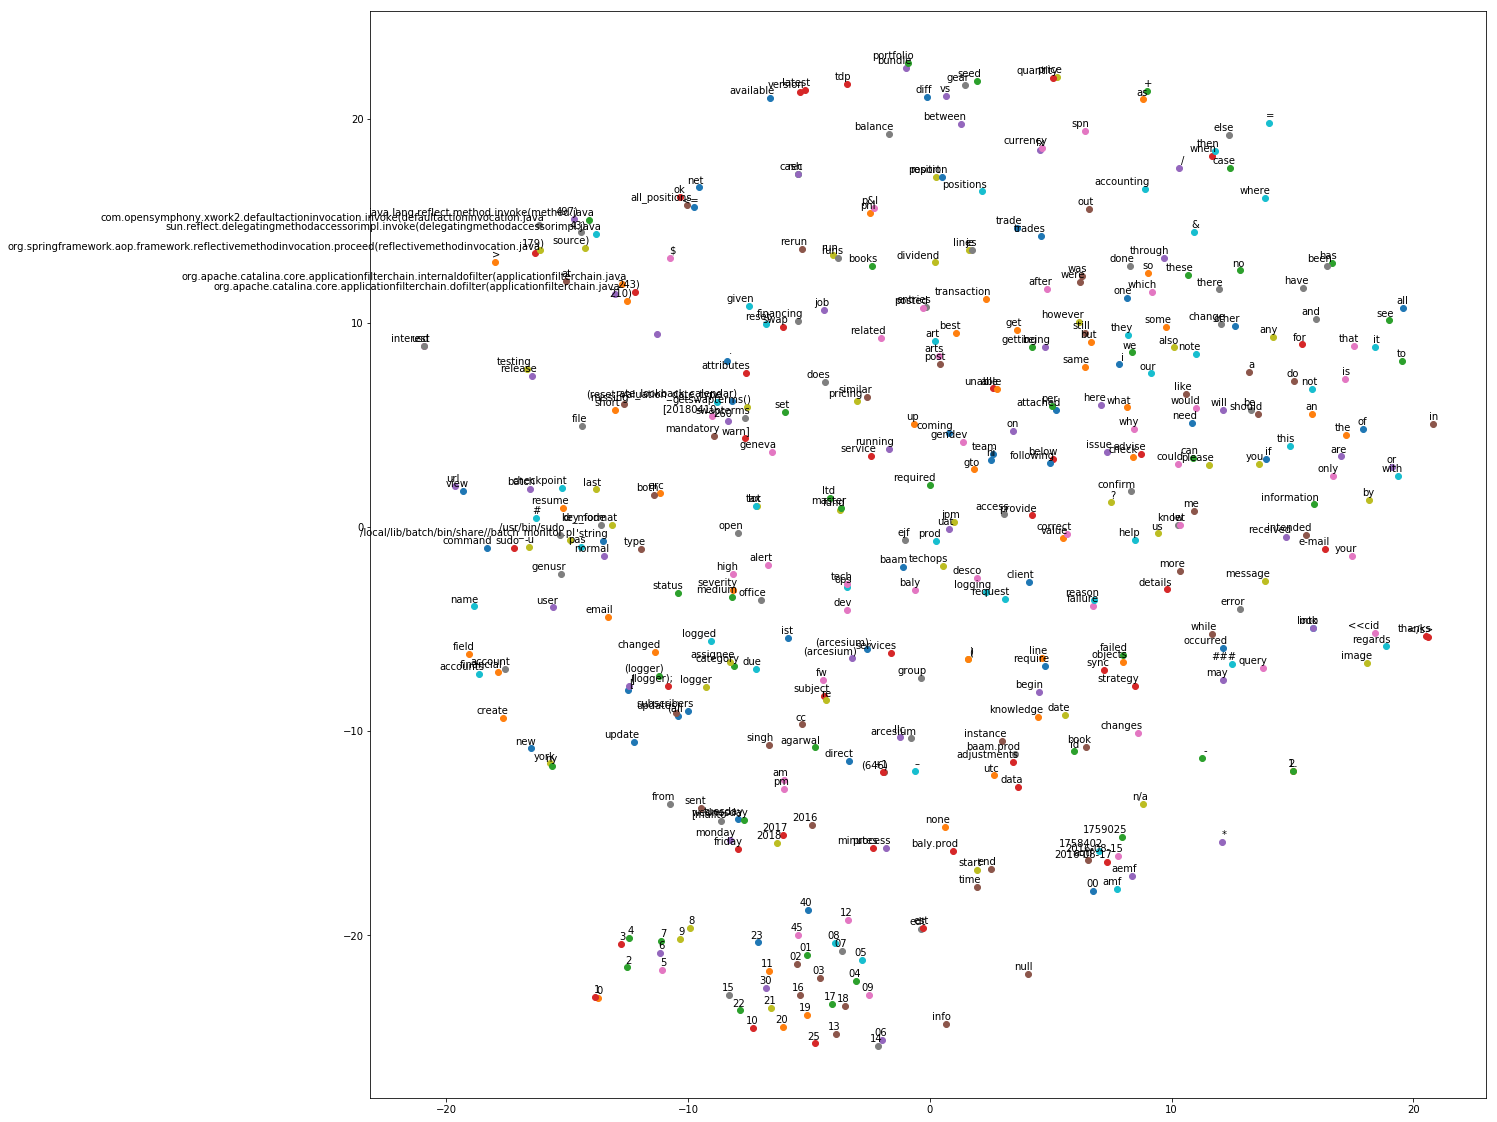

In [94]:

from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)